In [1]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from parameters import parameters as pm
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
#from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import timeit
import joblib

import warnings
warnings.filterwarnings('ignore')


In [2]:
df_1=pd.read_excel('../sampling/samples_para_stress_gamma_0.1.xlsx')  
df_2=pd.read_excel('../sampling/samples_para_stress_gamma_0.2.xlsx')
df_3=pd.read_excel('../sampling/samples_para_stress_gamma_0.3.xlsx') 
df_4=pd.read_excel('../sampling/samples_para_stress_gamma_0.4.xlsx')  
df_5=pd.read_excel('../sampling/samples_para_stress_gamma_0.5.xlsx')    

df_total=[df_1,df_2,df_3,df_4,df_5]

In [3]:
for i in df_total:
    i.columns=['a','b','af','bf','as','bs','afs','bfs','sigma_fs_fs','sigma_sf_fs','sigma_fn_fn','sigma_nf_fn','sigma_ns_sn','sigma_sn_sn']


In [4]:
df_1.describe()

,a,b,af,bf,as,bs,afs,bfs,sigma_fs_fs,sigma_sf_fs,sigma_fn_fn,sigma_nf_fn,sigma_ns_sn,sigma_sn_sn
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,5.503265,5.501516,5.503804,5.500101,5.496076,5.498827,5.502831,5.496800,1.174101,1.174086,0.592957,0.581944,0.581944,0.592942
std,2.598729,2.600133,2.597712,2.600761,2.597625,2.600409,2.599244,2.598767,0.397029,0.396899,0.276233,0.275966,0.275966,0.275853
min,1.006414,1.004174,1.000365,1.008132,1.001111,1.005108,1.003081,1.000456,0.232488,0.236602,0.111654,0.104331,0.104331,0.111772
25%,3.256919,3.247223,3.260273,3.250935,3.252458,3.251541,3.262341,3.248012,0.884686,0.883990,0.357609,0.346436,0.346436,0.356828
50%,5.505608,5.504290,5.503793,5.508426,5.496537,5.492069,5.503747,5.495852,1.165310,1.165822,0.589448,0.580246,0.580246,0.590887
75%,7.750166,7.751052,7.752172,7.753737,7.738573,7.749632,7.749186,7.743569,1.462445,1.466893,0.833344,0.820961,0.820961,0.831321
max,9.995596,9.998702,9.994417,9.992480,9.992159,9.995359,9.999022,9.991591,2.175565,2.175476,1.105667,1.091388,1.091388,1.107987


In [5]:
feature_columns=['sigma_fs_fs','sigma_sf_fs','sigma_fn_fn','sigma_nf_fn','sigma_ns_sn','sigma_sn_sn']
parameters = ['a','b','af','bf','as','bs','afs','bfs']

feature_columns=['sigma_fs_fs','sigma_sf_fs','sigma_fn_fn','sigma_nf_fn','sigma_ns_sn','sigma_sn_sn']
parameters = ['a','b','af','bf','as','bs','afs','bfs']
col_mean = np.zeros((5,6))
col_std  = np.zeros((5,6))

# for saving this, your future test, the direct prediction is for the standardalized value 

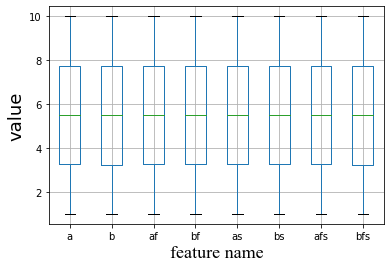

In [6]:
df_1[parameters].boxplot()
plt.gca().set_ylabel("value",fontdict={"size":18})
plt.gca().set_xlabel("feature name",fontdict={'family' : 'Times New Roman', 'size' : 18})
plt.show()

In [7]:
q_1data=df_1.iloc[:,0:8].values
q_2data=df_2.iloc[:,0:8].values
q_3data=df_3.iloc[:,0:8].values
q_4data=df_4.iloc[:,0:8].values
q_5data=df_5.iloc[:,0:8].values

y_1data=df_1.iloc[:,8:].values
y_2data=df_2.iloc[:,8:].values
y_3data=df_3.iloc[:,8:].values
y_4data=df_4.iloc[:,8:].values
y_5data=df_5.iloc[:,8:].values

In [8]:
train_size=int(0.9*len(q_1data))

In [9]:
def mse_loss(y_true,y_pred):
    return np.mean(np.square(y_true-y_pred))

X_1_train = q_1data[:train_size,:]
y_1_train = y_1data[:train_size,:]
X_1_test = q_1data[train_size:,:]
y_1_test = y_1data[train_size:,:]

X_2_train = q_2data[:train_size,:]
y_2_train = y_2data[:train_size,:]
X_2_test = q_2data[train_size:,:]
y_2_test = y_2data[train_size:,:]

X_3_train = q_3data[:train_size,:]
y_3_train = y_3data[:train_size,:]
X_3_test = q_3data[train_size:,:]
y_3_test = y_3data[train_size:,:]

X_4_train = q_4data[:train_size,:]
y_4_train = y_4data[:train_size,:]
X_4_test = q_4data[train_size:,:]
y_4_test = y_4data[train_size:,:]
    
X_5_train = q_5data[:train_size,:]
y_5_train = y_5data[:train_size,:]
X_5_test = q_5data[train_size:,:]
y_5_test = y_5data[train_size:,:]

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern,RationalQuadratic

In [11]:
#gamma 0.1
start = timeit.default_timer()
kernel = ConstantKernel(100, (1e-3, 1e3))*RBF(length_scale= 1.0, length_scale_bounds=(0.0,1000))
gpr_1models=[]
for feat_flag in range(6):
    gpr_1sub = GaussianProcessRegressor(kernel=kernel,
                    random_state=0)
    print('fitting feature %d' % feat_flag)
    gpr_1sub.fit(X_1_train, y_1_train[:, feat_flag])
    print(gpr_1sub.kernel_)
    gpr_1models.append(gpr_1sub)
    
stop = timeit.default_timer()
print('Time: ', stop - start)

# gamma 0.2
start = timeit.default_timer()
kernel = ConstantKernel(100, (1e-3, 1e3))*RBF(length_scale= 1.0, length_scale_bounds=(0.0,100))
gpr_2models=[]
for feat_flag in range(6):
    gpr_2sub = GaussianProcessRegressor(kernel=kernel,
                    random_state=0)
    print('fitting feature %d' % feat_flag)
    gpr_2sub.fit(X_2_train, y_2_train[:, feat_flag])
    print(gpr_2sub.kernel_)
    gpr_2models.append(gpr_2sub)
stop = timeit.default_timer()
print('Time: ', stop - start)


#gamma 0.3
start = timeit.default_timer()
kernel = ConstantKernel(100, (1e-3, 1e3))*RBF(length_scale= 1.0, length_scale_bounds=(0.0,100))
gpr_3models=[]
for feat_flag in range(6):
    gpr_3sub = GaussianProcessRegressor(kernel=kernel,
                    random_state=0)
    print('fitting feature %d' % feat_flag)
    gpr_3sub.fit(X_3_train, y_3_train[:, feat_flag])
    print(gpr_3sub.kernel_)
    gpr_3models.append(gpr_3sub)
stop = timeit.default_timer()
print('Time: ', stop - start)


#gamma 0.4
start = timeit.default_timer()
kernel = ConstantKernel(100, (1e-3, 1e3))*RBF(length_scale= 1.0, length_scale_bounds=(0.0,100))
gpr_4models=[]
for feat_flag in range(6):
    gpr_4sub = GaussianProcessRegressor(kernel=kernel,
                    random_state=0)
    print('fitting feature %d' % feat_flag)
    gpr_4sub.fit(X_4_train, y_4_train[:, feat_flag])
    print(gpr_4sub.kernel_)
    gpr_4models.append(gpr_4sub)
stop = timeit.default_timer()
print('Time: ', stop - start)

#gamma 0.5
start = timeit.default_timer()
kernel = ConstantKernel(100, (1e-3, 1e3))*RBF(length_scale= 1.0, length_scale_bounds=(0.0,100))
gpr_5models=[]
for feat_flag in range(6):
    gpr_5sub = GaussianProcessRegressor(kernel=kernel,
                    random_state=0)
    print('fitting feature %d' % feat_flag)
    gpr_5sub.fit(X_5_train, y_5_train[:, feat_flag])
    print(gpr_5sub.kernel_)
    gpr_5models.append(gpr_5sub)
stop = timeit.default_timer()
print('Time: ', stop - start)

fitting feature 0
31.6**2 * RBF(length_scale=325)
fitting feature 1
31.6**2 * RBF(length_scale=325)
fitting feature 2
31.6**2 * RBF(length_scale=363)
fitting feature 3
31.6**2 * RBF(length_scale=364)
fitting feature 4
31.6**2 * RBF(length_scale=364)
fitting feature 5
31.6**2 * RBF(length_scale=363)
Time:  56.70052430000001
fitting feature 0
31.6**2 * RBF(length_scale=88.6)
fitting feature 1
31.6**2 * RBF(length_scale=88.9)
fitting feature 2
31.6**2 * RBF(length_scale=97)
fitting feature 3
31.6**2 * RBF(length_scale=96.9)
fitting feature 4
31.6**2 * RBF(length_scale=96.9)
fitting feature 5
31.6**2 * RBF(length_scale=96.9)
Time:  45.61913099999998
fitting feature 0
31.6**2 * RBF(length_scale=39.3)
fitting feature 1
31.6**2 * RBF(length_scale=39.3)
fitting feature 2
31.6**2 * RBF(length_scale=43)
fitting feature 3
31.6**2 * RBF(length_scale=43)
fitting feature 4
31.6**2 * RBF(length_scale=43)
fitting feature 5
31.6**2 * RBF(length_scale=43)
Time:  48.968850299999986
fitting feature 0
31.6

In [12]:
for feat_flag in range(6):
    print('fitting feature %d' % feat_flag)
    gpr_1sub = gpr_1models[feat_flag]
    pred = gpr_1sub.predict(X_1_test)
    print('gpr Test: mse loss={:.6f} r2_score={:.6f}'.format(
        mse_loss(y_1_test[:, feat_flag], pred),metrics.r2_score(y_1_test[:, feat_flag], pred)))

fitting feature 0
gpr Test: mse loss=0.000000 r2_score=1.000000
fitting feature 1
gpr Test: mse loss=0.000000 r2_score=1.000000
fitting feature 2
gpr Test: mse loss=0.000000 r2_score=1.000000
fitting feature 3
gpr Test: mse loss=0.000000 r2_score=1.000000
fitting feature 4
gpr Test: mse loss=0.000000 r2_score=1.000000
fitting feature 5
gpr Test: mse loss=0.000000 r2_score=1.000000


In [13]:
gamma_val = np.array([0.1, 0.2, 0.3, 0.4, 0.5]).reshape(1,-1)
para_val = np.array([2,	5,	3,	6,	8,	7,	4,	8]).reshape(1,-1)


In [14]:
#predict for sigma_fs_fs
sigma_fs_fs = []
sigma_fs_fs.append(gpr_1models[0].predict(para_val) )
sigma_fs_fs.append(gpr_2models[0].predict(para_val) )
sigma_fs_fs.append(gpr_3models[0].predict(para_val) )
sigma_fs_fs.append(gpr_4models[0].predict(para_val) )
sigma_fs_fs.append(gpr_5models[0].predict(para_val) )

#predict for sigma_sf_fs
sigma_sf_fs = []
sigma_sf_fs.append(gpr_1models[1].predict(para_val) )
sigma_sf_fs.append(gpr_2models[1].predict(para_val) )
sigma_sf_fs.append(gpr_3models[1].predict(para_val) )
sigma_sf_fs.append(gpr_4models[1].predict(para_val) )
sigma_sf_fs.append(gpr_5models[1].predict(para_val) )

#predict for sigma_fn_fn
sigma_fn_fn = []
sigma_fn_fn.append(gpr_1models[2].predict(para_val) )
sigma_fn_fn.append(gpr_2models[2].predict(para_val) )
sigma_fn_fn.append(gpr_3models[2].predict(para_val) )
sigma_fn_fn.append(gpr_4models[2].predict(para_val) )
sigma_fn_fn.append(gpr_5models[2].predict(para_val) )

#predict for sigma_nf_fn
sigma_nf_fn = []
sigma_nf_fn.append(gpr_1models[3].predict(para_val) )
sigma_nf_fn.append(gpr_2models[3].predict(para_val) )
sigma_nf_fn.append(gpr_3models[3].predict(para_val) )
sigma_nf_fn.append(gpr_4models[3].predict(para_val) )
sigma_nf_fn.append(gpr_5models[3].predict(para_val) )

#predict for sigma_ns_sn
sigma_ns_sn = []
sigma_ns_sn.append(gpr_1models[4].predict(para_val) )
sigma_ns_sn.append(gpr_2models[4].predict(para_val) )
sigma_ns_sn.append(gpr_3models[4].predict(para_val) )
sigma_ns_sn.append(gpr_4models[4].predict(para_val) )
sigma_ns_sn.append(gpr_5models[4].predict(para_val) )

#predict for sigma_sn_sn
sigma_sn_sn = []
sigma_sn_sn.append(gpr_1models[5].predict(para_val) )
sigma_sn_sn.append(gpr_2models[5].predict(para_val) )
sigma_sn_sn.append(gpr_3models[5].predict(para_val) )
sigma_sn_sn.append(gpr_4models[5].predict(para_val) )
sigma_sn_sn.append(gpr_5models[5].predict(para_val) )


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import interp1d

In [21]:
# load the analytical solution 
df_test_analy=pd.read_excel('../sampling/test_stress_variedGamma.xlsx');
sigma_fs_fs_analy = df_test_analy.iloc[:,0].values;
sigma_sf_fs_analy = df_test_analy.iloc[:,1].values;
sigma_fn_fn_analy = df_test_analy.iloc[:,2].values;
sigma_nf_fn_analy = df_test_analy.iloc[:,3].values;
sigma_ns_sn_analy = df_test_analy.iloc[:,4].values;
sigma_sn_sn_analy = df_test_analy.iloc[:,5].values;
gamma_analy       = df_test_analy.iloc[:,6].values;

In [28]:
gamma_analy_new = gamma_analy[9:]
print(gamma_analy_new)

[0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37
 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]


In [24]:
sigma_fs_fs_analy_new = sigma_fs_fs_analy[9:]
sigma_sf_fs_analy_new = sigma_sf_fs_analy[9:]
sigma_fn_fn_analy_new = sigma_fn_fn_analy[9:]
sigma_nf_fn_analy_new = sigma_nf_fn_analy[9:]
sigma_ns_sn_analy_new = sigma_ns_sn_analy[9:]
sigma_sn_sn_analy_new = sigma_sn_sn_analy[9:]


In [25]:
gamma_val_T = np.transpose(gamma_val).squeeze()
sigma_fs_fs_ar = np.array(sigma_fs_fs).squeeze()
sigma_sf_fs_ar = np.array(sigma_sf_fs).squeeze()
sigma_fn_fn_ar = np.array(sigma_fn_fn).squeeze()
sigma_nf_fn_ar = np.array(sigma_nf_fn).squeeze()
sigma_ns_sn_ar = np.array(sigma_ns_sn).squeeze()
sigma_sn_sn_ar = np.array(sigma_sn_sn).squeeze()

In [26]:
f2 = interp1d(gamma_val_T, sigma_fs_fs_ar,kind='cubic')
f3 = interp1d(gamma_val_T, sigma_sf_fs_ar,kind='cubic')
f4 = interp1d(gamma_val_T, sigma_fn_fn_ar,kind='cubic')
f5 = interp1d(gamma_val_T, sigma_nf_fn_ar,kind='cubic')
f6 = interp1d(gamma_val_T, sigma_ns_sn_ar,kind='cubic')
f7 = interp1d(gamma_val_T, sigma_sn_sn_ar,kind='cubic')


In [29]:
fsa_1= f2(gamma_analy_new)-sigma_fs_fs_analy_new
fsa_2= f3(gamma_analy_new)-sigma_sf_fs_analy_new
fsa_3= f4(gamma_analy_new)-sigma_fn_fn_analy_new
fsa_4= f5(gamma_analy_new)-sigma_nf_fn_analy_new
fsa_5= f6(gamma_analy_new)-sigma_ns_sn_analy_new
fsa_6= f7(gamma_analy_new)-sigma_sn_sn_analy_new


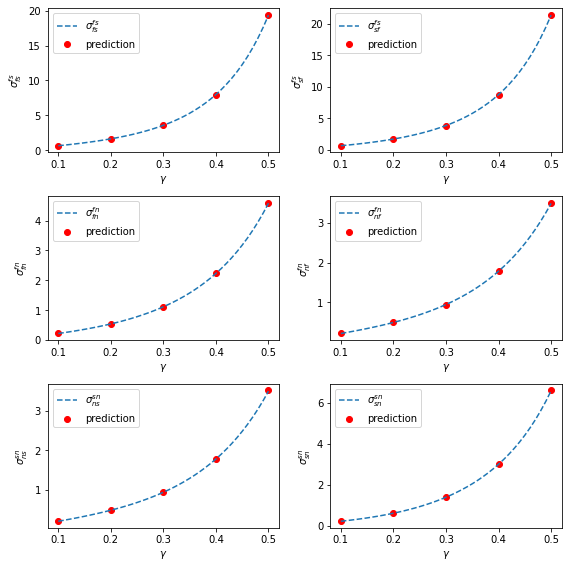

In [30]:
fig, axs = plt.subplots(3, 2, figsize=(8,8))
axs[0, 0].plot(gamma_analy_new, sigma_fs_fs_analy_new, linestyle='dashed', label=r'$\sigma_{fs}^{fs}$')
axs[0, 0].scatter(gamma_val, sigma_fs_fs,c='red', label='prediction')
axs[0, 0].set_xlabel(r'$\gamma$')
axs[0, 0].set_ylabel(r'$\sigma_{fs}^{fs}$')

axs[0, 1].plot(gamma_analy_new, sigma_sf_fs_analy_new, linestyle='dashed', label=r'$\sigma_{sf}^{fs}$')
axs[0, 1].scatter(gamma_val, sigma_sf_fs,c='red', label='prediction')
axs[0, 1].set_ylabel(r'$\sigma_{sf}^{fs}$')
axs[0, 1].set_xlabel(r'$\gamma$')

axs[1, 0].plot(gamma_analy_new, sigma_fn_fn_analy_new, linestyle='dashed', label=r'$\sigma_{fn}^{fn}$')
axs[1, 0].scatter(gamma_val, sigma_fn_fn,c='red', label='prediction')
axs[1, 0].set_ylabel(r'$\sigma_{fn}^{fn}$')
axs[1, 0].set_xlabel(r'$\gamma$')

axs[1, 1].plot(gamma_analy_new, sigma_nf_fn_analy_new, linestyle='dashed', label=r'$\sigma_{nf}^{fn}$')
axs[1, 1].scatter(gamma_val, sigma_nf_fn,c='red', label='prediction')
axs[1, 1].set_ylabel(r'$\sigma_{nf}^{fn}$')
axs[1, 1].set_xlabel(r'$\gamma$')

axs[2, 0].plot(gamma_analy_new, sigma_ns_sn_analy_new, linestyle='dashed', label=r'$\sigma_{ns}^{sn}$')
axs[2, 0].scatter(gamma_val, sigma_ns_sn,c='red', label='prediction')
axs[2, 0].set_ylabel(r'$\sigma_{ns}^{sn}$')
axs[2, 0].set_xlabel(r'$\gamma$')

axs[2, 1].plot(gamma_analy_new, sigma_sn_sn_analy_new, linestyle='dashed', label=r'$\sigma_{sn}^{sn}$')
axs[2, 1].scatter(gamma_val, sigma_sn_sn,c='red', label='prediction')
axs[2, 1].set_ylabel(r'$\sigma_{sn}^{sn}$')
axs[2, 1].set_xlabel(r'$\gamma$')

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[2,0].legend()
axs[2,1].legend()
plt.tight_layout()
plt.show()

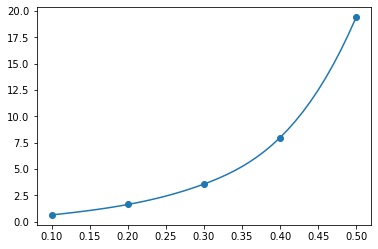

In [33]:
plt.scatter(gamma_val,sigma_fs_fs)
plt.plot(gamma_analy_new,f2(gamma_analy_new),'-')
plt.show()

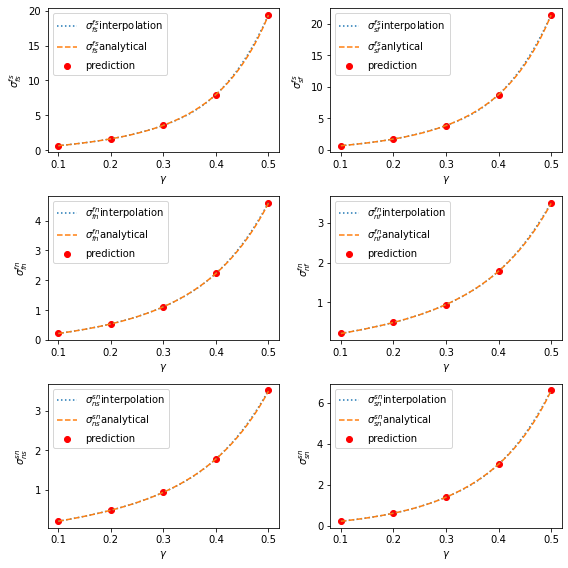

In [34]:
#plt.scatter(gamma_val,sigma_fs_fs)
#plt.plot(gamma_analy_new,f2(gamma_analy_new),'-')

fig, axs = plt.subplots(3, 2, figsize=(8,8))
axs[0, 0].plot(gamma_analy_new, f2(gamma_analy_new), linestyle='dotted', label=r'$\sigma_{fs}^{fs}$interpolation')
axs[0, 0].scatter(gamma_val, sigma_fs_fs,c='red', label='prediction')
axs[0, 0].set_xlabel(r'$\gamma$')
axs[0, 0].set_ylabel(r'$\sigma_{fs}^{fs}$')

axs[0, 1].plot(gamma_analy_new, f3(gamma_analy_new), linestyle='dotted', label=r'$\sigma_{sf}^{fs}$interpolation')
axs[0, 1].scatter(gamma_val, sigma_sf_fs,c='red', label='prediction')
axs[0, 1].set_ylabel(r'$\sigma_{sf}^{fs}$')
axs[0, 1].set_xlabel(r'$\gamma$')

axs[1, 0].plot(gamma_analy_new, f4(gamma_analy_new), linestyle='dotted', label=r'$\sigma_{fn}^{fn}$interpolation')
axs[1, 0].scatter(gamma_val, sigma_fn_fn,c='red', label='prediction')
axs[1, 0].set_ylabel(r'$\sigma_{fn}^{fn}$')
axs[1, 0].set_xlabel(r'$\gamma$')

axs[1, 1].plot(gamma_analy_new, f5(gamma_analy_new), linestyle='dotted', label=r'$\sigma_{nf}^{fn}$interpolation')
axs[1, 1].scatter(gamma_val, sigma_nf_fn,c='red', label='prediction')
axs[1, 1].set_ylabel(r'$\sigma_{nf}^{fn}$')
axs[1, 1].set_xlabel(r'$\gamma$')

axs[2, 0].plot(gamma_analy_new, f6(gamma_analy_new), linestyle='dotted', label=r'$\sigma_{ns}^{sn}$interpolation')
axs[2, 0].scatter(gamma_val, sigma_ns_sn,c='red', label='prediction')
axs[2, 0].set_ylabel(r'$\sigma_{ns}^{sn}$')
axs[2, 0].set_xlabel(r'$\gamma$')

axs[2, 1].plot(gamma_analy_new, f7(gamma_analy_new), linestyle='dotted', label=r'$\sigma_{sn}^{sn}$interpolation')
axs[2, 1].scatter(gamma_val, sigma_sn_sn,c='red', label='prediction')
axs[2, 1].set_ylabel(r'$\sigma_{sn}^{sn}$')
axs[2, 1].set_xlabel(r'$\gamma$')

axs[0, 0].plot(gamma_analy_new, sigma_fs_fs_analy_new, linestyle='dashed', label=r'$\sigma_{fs}^{fs}$analytical')
axs[0, 1].plot(gamma_analy_new, sigma_sf_fs_analy_new, linestyle='dashed', label=r'$\sigma_{sf}^{fs}$anlytical')
axs[1, 0].plot(gamma_analy_new, sigma_fn_fn_analy_new, linestyle='dashed', label=r'$\sigma_{fn}^{fn}$analytical')
axs[1, 1].plot(gamma_analy_new, sigma_nf_fn_analy_new, linestyle='dashed', label=r'$\sigma_{nf}^{fn}$analytical')
axs[2, 0].plot(gamma_analy_new, sigma_ns_sn_analy_new, linestyle='dashed', label=r'$\sigma_{ns}^{sn}$analytical')
axs[2, 1].plot(gamma_analy_new, sigma_sn_sn_analy_new, linestyle='dashed', label=r'$\sigma_{sn}^{sn}$analytical')

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[2,0].legend()
axs[2,1].legend()
plt.tight_layout()
plt.show()

In [35]:
from scipy.integrate import simps
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import math

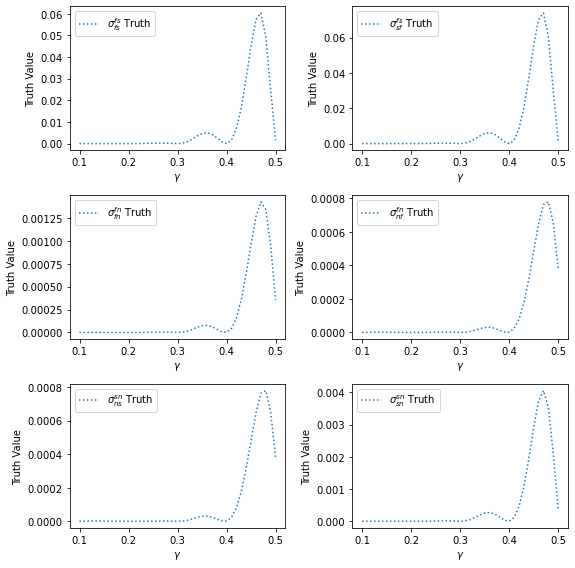

In [36]:
fig, axs = plt.subplots(3, 2, figsize=(8,8))
axs[0, 0].plot(gamma_analy_new, fsa_1**2, linestyle='dotted', label=r'$\sigma_{fs}^{fs}$ Truth')
axs[0, 0].set_xlabel(r'$\gamma$')
axs[0, 0].set_ylabel('Truth Value')

axs[0, 1].plot(gamma_analy_new, fsa_2**2, linestyle='dotted', label=r'$\sigma_{sf}^{fs}$ Truth')
axs[0, 1].set_ylabel('Truth Value')
axs[0, 1].set_xlabel(r'$\gamma$')

axs[1, 0].plot(gamma_analy_new, fsa_3**2, linestyle='dotted', label=r'$\sigma_{fn}^{fn}$ Truth')
axs[1, 0].set_ylabel('Truth Value')
axs[1, 0].set_xlabel(r'$\gamma$')

axs[1, 1].plot(gamma_analy_new, fsa_4**2, linestyle='dotted', label=r'$\sigma_{nf}^{fn}$ Truth')
axs[1, 1].set_ylabel('Truth Value')
axs[1, 1].set_xlabel(r'$\gamma$')

axs[2, 0].plot(gamma_analy_new, fsa_5**2, linestyle='dotted', label=r'$\sigma_{ns}^{sn}$ Truth')
axs[2, 0].set_ylabel('Truth Value')
axs[2, 0].set_xlabel(r'$\gamma$')

axs[2, 1].plot(gamma_analy_new, fsa_6**2, linestyle='dotted', label=r'$\sigma_{sn}^{sn}$ Truth')
axs[2, 1].set_ylabel('Truth Value')
axs[2, 1].set_xlabel(r'$\gamma$')

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[2,0].legend()
axs[2,1].legend()
plt.tight_layout()
plt.show()